In [2]:
import os
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, efficientnet_b0
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Download dataset using kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("kaustubhb999/tomatoleaf")
print("Dataset downloaded to:", dataset_path)
print("Files in folder:", os.listdir(dataset_path))

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Dataset downloaded to: /kaggle/input/tomatoleaf
Files in folder: ['tomato']
Using device: cuda


In [4]:
import os
import shutil
import random
import matplotlib.pyplot as plt

dataset_path = "/kaggle/input/tomatoleaf"

# Locate the 'tomato' folder
tomato_dir = os.path.join(dataset_path, "tomato")
if not os.path.exists(tomato_dir):
    subdirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for subdir in subdirs:
        potential_path = os.path.join(dataset_path, subdir, "tomato")
        if os.path.exists(potential_path):
            tomato_dir = potential_path
            break

# Find original train and val folders
original_train_dir = os.path.join(tomato_dir, 'train')
original_val_dir = os.path.join(tomato_dir, 'val')

# Confirm paths
print(f"Using train from: {original_train_dir}")
print(f"Using val (for validation) from: {original_val_dir}")

# Function to split train into train/test
def split_train_test(source_dir, target_dir, train_ratio=0.8):
    train_dir = os.path.join(target_dir, 'train')
    test_dir = os.path.join(target_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    classes = [cls for cls in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, cls))]

    for cls in classes:
        src_cls_path = os.path.join(source_dir, cls)
        images = [img for img in os.listdir(src_cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        split_idx = int(len(images) * train_ratio)
        train_imgs = images[:split_idx]
        test_imgs = images[split_idx:]

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(src_cls_path, img), os.path.join(train_dir, cls, img))
        for img in test_imgs:
            shutil.copy(os.path.join(src_cls_path, img), os.path.join(test_dir, cls, img))

    print("Split complete.")

# Perform the split and define final paths
split_dataset_dir = os.path.join('/kaggle/working', 'dataset_split')
os.makedirs(split_dataset_dir, exist_ok=True)

split_train_test(original_train_dir, split_dataset_dir, train_ratio=0.8)

# Set final directory paths
train_dir = os.path.join(split_dataset_dir, 'train')
test_dir = os.path.join(split_dataset_dir, 'test')
val_dir = original_val_dir  # Full original val folder for validation

# Count function
def count_images(directory):
    if not os.path.exists(directory):
        return {}
    return {
        cls: len([
            f for f in os.listdir(os.path.join(directory, cls))
            if os.path.isfile(os.path.join(directory, cls, f))
        ]) for cls in os.listdir(directory) if os.path.isdir(os.path.join(directory, cls))
    }

# Print stats
train_count = count_images(train_dir)
test_count = count_images(test_dir)
val_count = count_images(val_dir)

print(f"Train images: {sum(train_count.values())}")
print(f"Test images: {sum(test_count.values())}")
print(f"Validation images: {sum(val_count.values())}")

# Optional: print class distribution
print("\nClass distribution in training set:")
for cls, count in train_count.items():
    print(f"{cls}: {count}")


Using train from: /kaggle/input/tomatoleaf/tomato/train
Using val (for validation) from: /kaggle/input/tomatoleaf/tomato/val
Split complete.
Train images: 8000
Test images: 2000
Validation images: 1000

Class distribution in training set:
Tomato___Early_blight: 800
Tomato___Tomato_mosaic_virus: 800
Tomato___Bacterial_spot: 800
Tomato___Target_Spot: 800
Tomato___Spider_mites Two-spotted_spider_mite: 800
Tomato___healthy: 800
Tomato___Septoria_leaf_spot: 800
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 800
Tomato___Late_blight: 800
Tomato___Leaf_Mold: 800


Train images = 8000
Test images = 2000
Validation images = 1000

Class distribution in training set:
Tomato___Early_blight: 800
Tomato___Tomato_mosaic_virus: 800
Tomato___Bacterial_spot: 800
Tomato___Target_Spot: 800
Tomato___Spider_mites Two-spotted_spider_mite: 800
Tomato___healthy: 800
Tomato___Septoria_leaf_spot: 800
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 800
Tomato___Late_blight: 800
Tomato___Leaf_Mold: 800


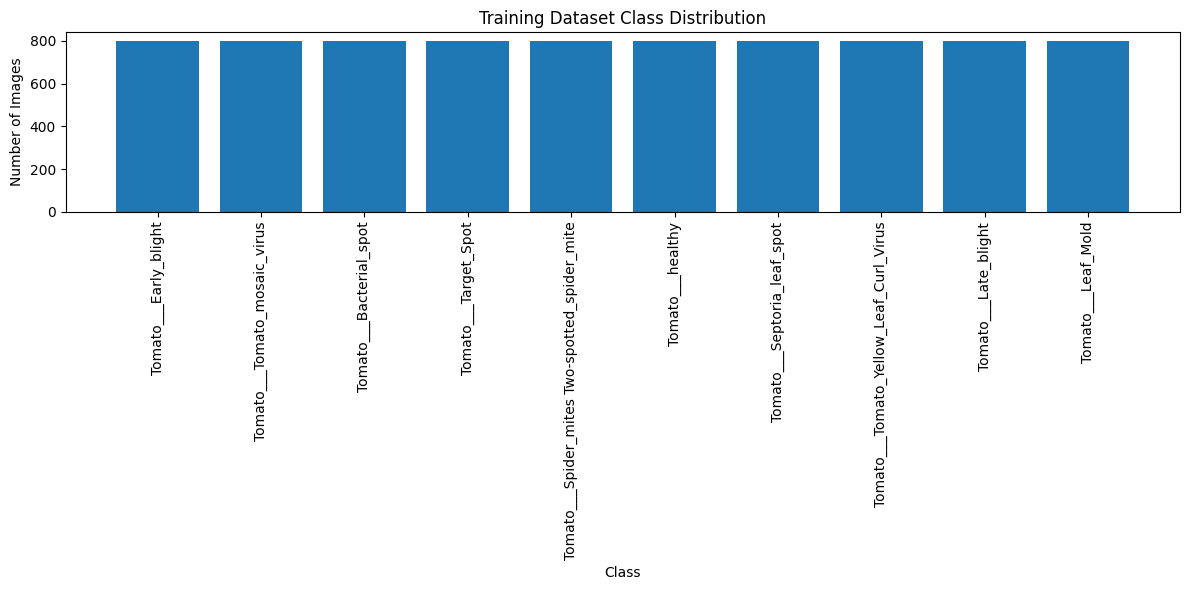

In [5]:
# 3. Function to count images in each class
def count_images(directory):
    """Count the number of images in each class directory"""
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist!")
        return {}

    categories = os.listdir(directory)
    categories_count = {category: len(os.listdir(os.path.join(directory, category)))
                        for category in categories if os.path.isdir(os.path.join(directory, category))}
    return categories_count

# Count images in each set
try:
    train_count = count_images(train_dir)
    if test_dir and os.path.exists(test_dir):
        test_count = count_images(test_dir)
    val_count = count_images(val_dir)

    # Display counts
    print(f'Train images = {sum(train_count.values())}')
    if test_dir and os.path.exists(test_dir):
        print(f'Test images = {sum(test_count.values())}')
    print(f'Validation images = {sum(val_count.values())}')

    # Display class distribution
    print("\nClass distribution in training set:")
    for cls, count in train_count.items():
        print(f"{cls}: {count}")

    # Visualization of class distribution
    plt.figure(figsize=(12, 6))
    plt.bar(train_count.keys(), train_count.values())
    plt.xticks(rotation=90)
    plt.title('Training Dataset Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error counting images: {e}")

In [6]:
# 4. Create a custom dataset class for binary classification (healthy vs. unhealthy)
class TomatoLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.binary_labels = []  # 0 for unhealthy, 1 for healthy
        self.class_to_idx = {}  # To store class mapping
        # Check if directory exists
        if not os.path.exists(root_dir):
            print(f"Warning: Directory {root_dir} does not exist!")
            return

        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        print(f"Found classes: {self.classes}")
        # Collect image paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            # Determine binary label (healthy or unhealthy)
            is_healthy = 1 if (
                "healthy" in class_name.lower() or
                "health" in class_name.lower() or
                "normal" in class_name.lower() or
                not any(disease in class_name.lower() for disease in [
                    "blight", "spot", "mold", "virus", "bacterial",
                    "mosaic", "miner", "curl", "target", "septoria",
                    "wilt", "yellowing", "pest"
                ])
            ) else 0

            # Store the mapping for debugging
            self.class_to_idx[class_name] = is_healthy

            # Count images in this class
            count = 0
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.binary_labels.append(is_healthy)
                    count += 1

            print(f"Class: {class_name}, Binary label: {'Healthy' if is_healthy else 'Unhealthy'}, Images: {count}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        binary_label = self.binary_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, binary_label

In [7]:
# 5. Define data transformations and augmentation
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test/Validation transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# 6. Create datasets
try:
    # Create datasets
    train_dataset = TomatoLeafDataset(train_dir, transform=train_transform)
    if test_dir and os.path.exists(test_dir):
        test_dataset = TomatoLeafDataset(test_dir, transform=test_transform)
    val_dataset = TomatoLeafDataset(val_dir, transform=test_transform)

    # Print dataset sizes
    print(f"Training dataset: {len(train_dataset)} images")
    if test_dir and os.path.exists(test_dir):
        print(f"Test dataset: {len(test_dataset)} images")
    print(f"Validation dataset: {len(val_dataset)} images")

    # Calculate class distribution in binary format
    train_healthy = sum(train_dataset.binary_labels)
    train_unhealthy = len(train_dataset.binary_labels) - train_healthy
    print(f"Training binary distribution: Healthy={train_healthy}, Unhealthy={train_unhealthy}")

    val_healthy = sum(val_dataset.binary_labels)
    val_unhealthy = len(val_dataset.binary_labels) - val_healthy
    print(f"Validation binary distribution: Healthy={val_healthy}, Unhealthy={val_unhealthy}")
except Exception as e:
    print(f"Error creating datasets: {e}")
    # Create dummy datasets for code to run if there's an issue
    class DummyDataset(Dataset):
        def __init__(self, size=100):
            self.binary_labels = [random.randint(0, 1) for _ in range(size)]
            self.size = size

        def __len__(self):
            return self.size

        def __getitem__(self, idx):
            return torch.randn(3, 224, 224), self.binary_labels[idx]

    print("Creating dummy datasets for demonstration")
    train_dataset = DummyDataset(500)
    test_dataset = DummyDataset(100)
    val_dataset = DummyDataset(100)
    print("Dummy datasets created")


Found classes: ['Tomato___Early_blight', 'Tomato___Tomato_mosaic_virus', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Late_blight', 'Tomato___Leaf_Mold']
Class: Tomato___Early_blight, Binary label: Unhealthy, Images: 800
Class: Tomato___Tomato_mosaic_virus, Binary label: Unhealthy, Images: 800
Class: Tomato___Bacterial_spot, Binary label: Unhealthy, Images: 800
Class: Tomato___Target_Spot, Binary label: Unhealthy, Images: 800
Class: Tomato___Spider_mites Two-spotted_spider_mite, Binary label: Unhealthy, Images: 800
Class: Tomato___healthy, Binary label: Healthy, Images: 800
Class: Tomato___Septoria_leaf_spot, Binary label: Unhealthy, Images: 800
Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Binary label: Unhealthy, Images: 800
Class: Tomato___Late_blight, Binary label: Unhealthy, Images: 800
Class: Tomato___Leaf_Mold, Binary labe

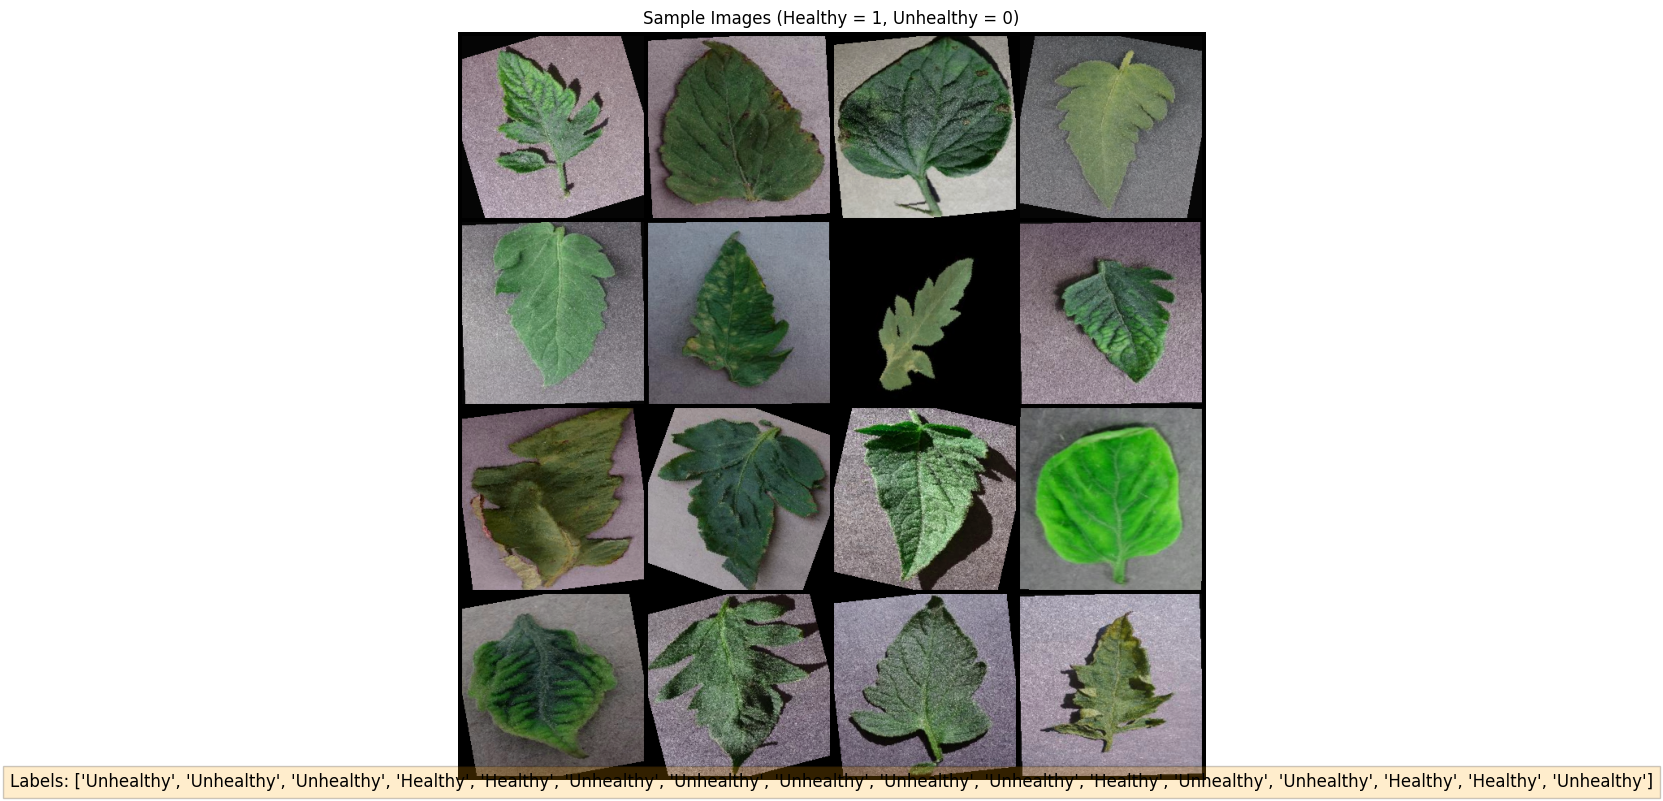

In [9]:
# 7. Create DataLoaders
# Calculate class weights for dealing with imbalance
train_labels = torch.tensor(train_dataset.binary_labels)
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
sample_weights = class_weights[train_labels]

# Create weighted sampler to handle class imbalance
weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_dataset),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=weighted_sampler,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

if 'test_dataset' in locals():
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# Function to display sample images
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    images = images.cpu()

    # Un-normalize images for display
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # Create grid and display
    plt.figure(figsize=(15, 8))
    grid = make_grid(images[:16], nrow=4, padding=5)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Sample Images (Healthy = 1, Unhealthy = 0)')
    plt.axis('off')

    # Display labels below images
    binary_labels = labels[:16].tolist()
    label_texts = [f"Healthy" if label == 1 else "Unhealthy" for label in binary_labels]

    plt.figtext(0.5, 0.01, f"Labels: {label_texts}", ha="center", fontsize=12,
                bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    plt.tight_layout()
    plt.show()

# Display sample batch
try:
    show_batch(train_loader)
except Exception as e:
    print(f"Could not display batch: {e}")

In [10]:
# 8. Define the hybrid model architecture combining custom CNN and pre-trained model
class HybridTomatoModel(nn.Module):
    def __init__(self, feature_fusion='concat', pretrained_model='resnet18'):
        super(HybridTomatoModel, self).__init__()

        # Custom CNN part
        self.custom_cnn = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional block
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth convolutional block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Custom CNN feature dimension (after flattening)
        # Input: 224x224 -> After 4 MaxPool layers: 14x14
        self.custom_feature_dim = 128 * 14 * 14

        # Pre-trained model part
        if pretrained_model == 'resnet18':
            self.pretrained = resnet18(weights='DEFAULT')
            # Remove final FC layer
            self.pretrained_feature_dim = self.pretrained.fc.in_features  # 512
            self.pretrained = nn.Sequential(*list(self.pretrained.children())[:-1])
        else:  # efficientnet_b0
            self.pretrained = efficientnet_b0(weights='DEFAULT')
            # Get feature dimension
            self.pretrained_feature_dim = self.pretrained.classifier[1].in_features  # 1280
            # Remove classifier
            self.pretrained.classifier = nn.Identity()

        # Feature fusion method
        self.feature_fusion = feature_fusion

        # For concatenation fusion
        if feature_fusion == 'concat':
            self.fusion_dim = self.custom_feature_dim + self.pretrained_feature_dim
        # For addition fusion (features must have same dimensions)
        elif feature_fusion == 'add':
            # Project custom features to match pretrained feature dimensions
            self.custom_projector = nn.Linear(self.custom_feature_dim, self.pretrained_feature_dim)
            self.fusion_dim = self.pretrained_feature_dim

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Binary classification
        )

    def forward(self, x):
        # Extract features from custom CNN
        custom_features = self.custom_cnn(x)
        custom_features = custom_features.view(custom_features.size(0), -1)  # Flatten

        # Extract features from pre-trained model
        pretrained_features = self.pretrained(x)
        pretrained_features = pretrained_features.view(pretrained_features.size(0), -1)  # Flatten

        # Fuse features
        if self.feature_fusion == 'concat':
            # Concatenate features
            fused_features = torch.cat((custom_features, pretrained_features), dim=1)
        elif self.feature_fusion == 'add':
            # Project custom features to match dimensions
            custom_features = self.custom_projector(custom_features)
            # Add features
            fused_features = custom_features + pretrained_features

        # Apply classification head
        logits = self.classifier(fused_features)
        return logits.squeeze()  # Remove last dimension for BCE loss

In [11]:
# 9. Initialize the model with selected parameters
model = HybridTomatoModel(
    feature_fusion='concat',  # 'concat' or 'add'
    pretrained_model='resnet18'  # 'resnet18' or 'efficientnet_b0'
).to(device)

# Freeze CNN backbone
for param in model.custom_cnn.parameters():  # Changed from model.cnn to model.custom_cnn
    param.requires_grad = False

print(model)

# Calculate trainable model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


HybridTomatoModel(
  (custom_cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [12]:
#10. Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# 11. Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)

        # Convert outputs to predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Update metrics
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    # Calculate metrics
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Additional metrics
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return epoch_loss, epoch_acc, precision, recall, f1

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)

            # Convert outputs to predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # Update metrics
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Additional metrics
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return epoch_loss, epoch_acc, precision, recall, f1, cm

In [14]:
# 12. Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=30, patience=5, device=device):

    # Create a directory to save models
    os.makedirs('model_checkpoints', exist_ok=True)
    model_save_path = os.path.join('model_checkpoints', 'best_tomato_hybrid_model.pth')

    # Initialize tracking variables
    best_val_f1 = 0.0
    epochs_no_improve = 0

    # History for plotting
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Train
        train_loss, train_acc, train_precision, train_recall, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validate
        val_loss, val_acc, val_precision, val_recall, val_f1, confusion_mat = validate(
            model, val_loader, criterion, device
        )

        # Update learning rate
        scheduler.step(val_f1)

        # Print statistics
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}')
        print(f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            # Save best model
            torch.save(model.state_dict(), model_save_path)
            print(f'New best model saved with F1: {val_f1:.4f}')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs')

            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

        print()

    # Load best model
    if os.path.exists(model_save_path):
        model.load_state_dict(torch.load(model_save_path))
        print(f"Loaded best model from {model_save_path}")

    return model, history

In [15]:
try:
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10,
        patience=5,
        device=device)
except Exception as e:
    print(f"An error occurred: {e}")

Epoch 1/10
----------


Training: 100%|██████████| 250/250 [01:06<00:00,  3.77it/s, loss=0.00853, acc=96.1]


Train Loss: 0.0992 Acc: 0.9614 F1: 0.9613
Val Loss: 0.0204 Acc: 0.9890 F1: 0.9479
Precision: 0.9009 Recall: 1.0000
New best model saved with F1: 0.9479

Epoch 2/10
----------


Training: 100%|██████████| 250/250 [01:05<00:00,  3.80it/s, loss=0.0101, acc=99]


Train Loss: 0.0304 Acc: 0.9904 F1: 0.9904
Val Loss: 0.0056 Acc: 0.9970 F1: 0.9852
Precision: 0.9709 Recall: 1.0000
New best model saved with F1: 0.9852

Epoch 3/10
----------


Training: 100%|██████████| 250/250 [01:03<00:00,  3.92it/s, loss=0.00126, acc=99.4]


Train Loss: 0.0194 Acc: 0.9941 F1: 0.9941
Val Loss: 0.0037 Acc: 0.9990 F1: 0.9950
Precision: 0.9901 Recall: 1.0000
New best model saved with F1: 0.9950

Epoch 4/10
----------


Training: 100%|██████████| 250/250 [01:06<00:00,  3.79it/s, loss=0.00103, acc=99.6]


Train Loss: 0.0116 Acc: 0.9956 F1: 0.9956
Val Loss: 0.0024 Acc: 0.9990 F1: 0.9950
Precision: 0.9901 Recall: 1.0000
No improvement for 1 epochs

Epoch 5/10
----------


Training: 100%|██████████| 250/250 [01:04<00:00,  3.90it/s, loss=0.0177, acc=99.5]


Train Loss: 0.0179 Acc: 0.9949 F1: 0.9950
Val Loss: 0.0024 Acc: 0.9990 F1: 0.9950
Precision: 1.0000 Recall: 0.9900
No improvement for 2 epochs

Epoch 6/10
----------


Training: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s, loss=0.0136, acc=99.4]


Train Loss: 0.0167 Acc: 0.9944 F1: 0.9944
Val Loss: 0.0039 Acc: 0.9990 F1: 0.9950
Precision: 1.0000 Recall: 0.9900
No improvement for 3 epochs

Epoch 7/10
----------


Training: 100%|██████████| 250/250 [01:04<00:00,  3.89it/s, loss=4.66e-5, acc=99.8]


Train Loss: 0.0077 Acc: 0.9976 F1: 0.9976
Val Loss: 0.0003 Acc: 1.0000 F1: 1.0000
Precision: 1.0000 Recall: 1.0000
New best model saved with F1: 1.0000

Epoch 8/10
----------


Training: 100%|██████████| 250/250 [01:05<00:00,  3.80it/s, loss=0.00814, acc=99.8]


Train Loss: 0.0057 Acc: 0.9984 F1: 0.9984
Val Loss: 0.0004 Acc: 1.0000 F1: 1.0000
Precision: 1.0000 Recall: 1.0000
No improvement for 1 epochs

Epoch 9/10
----------


Training: 100%|██████████| 250/250 [01:04<00:00,  3.87it/s, loss=0.000892, acc=99.7]


Train Loss: 0.0142 Acc: 0.9965 F1: 0.9965
Val Loss: 0.0618 Acc: 0.9820 F1: 0.9174
Precision: 0.8475 Recall: 1.0000
No improvement for 2 epochs

Epoch 10/10
----------


Training: 100%|██████████| 250/250 [01:05<00:00,  3.83it/s, loss=0.000107, acc=99.9]


Train Loss: 0.0044 Acc: 0.9986 F1: 0.9986
Val Loss: 0.0002 Acc: 1.0000 F1: 1.0000
Precision: 1.0000 Recall: 1.0000
No improvement for 3 epochs

Loaded best model from model_checkpoints/best_tomato_hybrid_model.pth


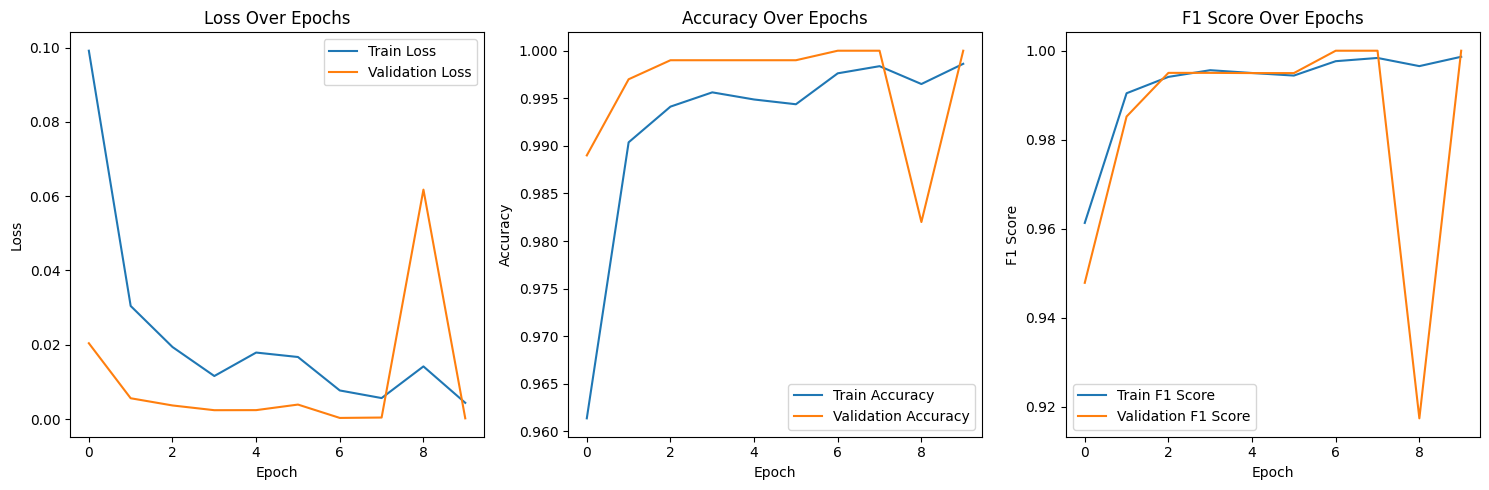

In [16]:
# 14. Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score plot
plt.subplot(1, 3, 3)
plt.plot(history['train_f1'], label='Train F1 Score')
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# 15. Evaluate best model on validation set
model_save_path = os.path.join('model_checkpoints', 'best_tomato_hybrid_model.pth')
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    print(f"Loaded best model from {model_save_path}")

val_loss, val_acc, val_precision, val_recall, val_f1, conf_matrix = validate(
    model, val_loader, criterion, device
)

print(f"Best Model Performance:")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Loaded best model from model_checkpoints/best_tomato_hybrid_model.pth
Best Model Performance:
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000


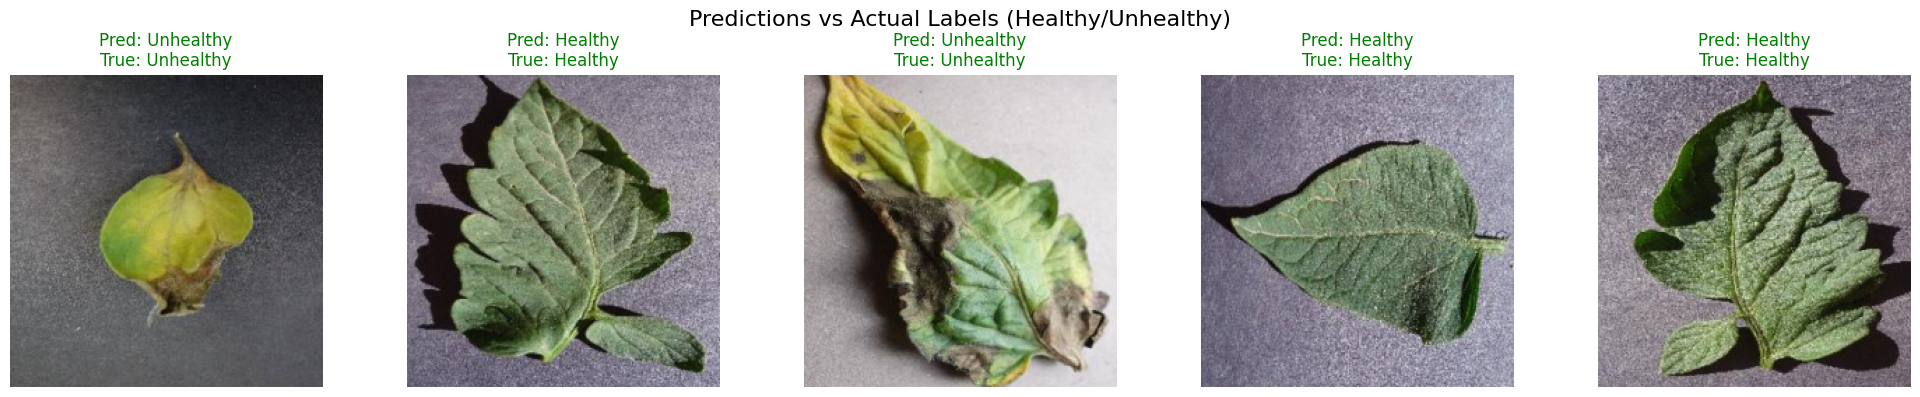

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import random

# Set model to evaluation mode
model.eval()

# Function to denormalize images (same as before)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Function to get predictions for a batch of images (same as before)
def get_predictions(images, model, device):
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()  # Binary prediction (0 or 1)
    return preds.cpu()

# --- Get a balanced set of images for testing ---
# Assuming you have 'val_dataset' as your validation dataset
healthy_indices = [i for i, (_, label) in enumerate(val_dataset) if label == 1]
unhealthy_indices = [i for i, (_, label) in enumerate(val_dataset) if label == 0]

# Take a balanced sample from each class
num_samples_per_class = min(len(healthy_indices), len(unhealthy_indices))
balanced_indices = healthy_indices[:num_samples_per_class] + unhealthy_indices[:num_samples_per_class]

# Shuffle the indices
random.shuffle(balanced_indices)

# Create a subset of the dataset with balanced classes
balanced_subset = torch.utils.data.Subset(val_dataset, balanced_indices)

# Create a DataLoader for the balanced subset
balanced_loader = torch.utils.data.DataLoader(
    balanced_subset, batch_size=32, shuffle=False
)

# --- Plot images with predictions and true labels ---
num_images_to_plot = 5  # Number of images to display

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 4))
fig.suptitle('Predictions vs Actual Labels (Healthy/Unhealthy)', fontsize=16)

images, labels = next(iter(balanced_loader))  # Get a batch of images

preds = get_predictions(images, model, device)

for i in range(num_images_to_plot):
    img = denormalize(images[i].cpu())
    img = np.transpose(img.numpy(), (1, 2, 0))
    pred_label = "Healthy" if preds[i].item() == 1 else "Unhealthy"
    true_label = "Healthy" if labels[i].item() == 1 else "Unhealthy"

    axes[i].imshow(img)
    title_color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()